# Online Analysis

Being able to visualize and interpret simulation data in real time is
invaluable for understanding the behavior of a physical system.

SmartSim can be used to stream data from Fortran, C, and C++ simulations
to Python where visualization is significantly easier and more interactive.

This example shows how to use SmartSim analyze the vorticity field during a simple,
Python based Lattice Boltzmann fluid flow simulation.

## Lattice Boltzmann Simulation

This example was adapted from Philip Mocz's [implementation](https://github.com/pmocz/latticeboltzmann-python)
of the lattice Boltzmann method in Python. Since that example is licensed under GPL, so is this example.

Philip also wrote a great medium [article](https://medium.com/swlh/create-your-own-lattice-boltzmann-simulation-with-python-8759e8b53b1c) explaining the simulation in detail.

<img src="https://github.com/CrayLabs/SmartSim/blob/develop/doc/images/latticeboltzmann.png?raw=true" alt="lattice" width="600"/>


## Integrating SmartRedis

Typically HPC simulations are written in C, C++, Fortran or other high performance
languages. Embedding the SmartRedis client usually involves compiling in the
SmartRedis library into the simulation.

Because this simulation is written in Python, we can use the SmartRedis
Python client to stream data to the database. To make the visualization easier,
we use the SmartRedis
[Dataset](https://www.craylabs.org/docs/sr_data_structures.html#dataset) object
to hold two 2D NumPy arrays. A convenience function is provided to convert
the fields into a dataset object.


```python
    # Select lines from updated simulation code highlighting
    # the use of SmartRedis to stream data to another processes

    from smartredis import Client, Dataset
    client = Client() # Addresses passed to job through SmartSim launch

    # send cylinder location only once
    client.put_tensor("cylinder", cylinder.astype(np.int8))

    for i in range(time_steps):
        # send every 5 time_step to reduce memory consumption
        if time_step % 5 == 0:
            dataset = create_dataset(time_step, ux, uy)
            client.put_dataset(dataset)

    def create_dataset(time_step, ux, uy):
        """Create SmartRedis Dataset containing multiple NumPy arrays
        to be stored at a single key within the database"""
        dataset = Dataset(f"data_{time_step}")
        dataset.add_tensor("ux", ux)
        dataset.add_tensor("uy", uy)
        return dataset
```

This is all the SmartRedis code needed to stream the simulation data. Note that
the client does not need to have an address explicitly stated because we
are going to be launching the simulation through SmartSim as shown in the
cell below



In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from smartredis import Client
from smartsim import Experiment
from vishelpers import plot_lattice_vorticity

## Starting the Experiment

SmartSim, the infrastructure library, is used here to launch both the
database and the simulation locally, but in separate processes. The example
is designed to run on laptops, so the local launcher is used.


First the necessary libraries are imported and an `Experiment` instance is created.
An `Orchestrator` database reference is intialized and launched 
to stage data between the simulation and this notebook where we will be
performing the analysis.

In [2]:
# Initialize an Experiment with the local launcher
# This will be the name of the output directory that holds
# the output from our simulation and SmartSim
exp = Experiment("finite_volume_simulation", launcher="local")

In [3]:
# create an Orchestrator database reference, 
# generate it's output directory, and launch it locally
db = exp.create_database(port=6780, interface="lo")
exp.generate(db, overwrite=True)
exp.start(db)
print(f"Database started at address: {db.get_address()}")

21:45:54 164b15ef4beb SmartSim[929] INFO Working in previously created experiment
Database started at address: ['127.0.0.1:6780']


## Running the Simulation

To run the simulation, `Experiment.create_run_settings` is used to define how the
simulation should be executed. These settings are then passed to create a
reference to the simulation through a call to `Experiment.create_model()` which
can be used to start, monitor, and stop the simulation from this notebook.


Once the model is defined it is started by passing the reference to `Experiment.start()`
The simulation is started with the `block=False` argument. This runs the simulation
in a nonblocking manner so that the data being streamed from the simulation can be
analyzed in real time.


In [4]:
# set simulation parameters we can pass as executable arguments
time_steps, seed = 2000, 42

# create "run settings" for the simulation which define how
# the simulation will be executed when passed to Experiment.start()
settings = exp.create_run_settings("/opt/conda/envs/smartsim/bin/python",
                                   exe_args=["fv_sim.py",
                                             f"--seed={seed}",
                                             f"--steps={time_steps}"])

# Create the Model reference to our simulation and
# attach needed files to be copied, configured, or symlinked into
# the Model directory at runtime. 
model = exp.create_model("fv_simulation", settings)
model.attach_generator_files(to_copy="fv_sim.py")
exp.generate(model, overwrite=True)

21:46:14 164b15ef4beb SmartSim[929] INFO Working in previously created experiment


In [5]:
# start simulation without blocking so data can be analyzed in real time
exp.start(model, block=False, summary=True)


21:46:14 164b15ef4beb SmartSim[929] INFO 

=== Launch Summary ===
Experiment: finite_volume_simulation
Experiment Path: /run/determined/workdir/SmartSim/tutorials/online_analysis/lattice/finite_volume_simulation
Launcher: local
Models: 1
Database Status: active

=== Models ===
fv_simulation
Executable: /opt/conda/envs/smartsim/bin/python
Executable Arguments: fv_sim.py --seed=42 --steps=2000





## Online Visualization

SmartRedis is used to pull the Datasets stored in the Orchestrator
database by the simulation and use matplotlib to plot the results.

In this example, we are running the visualization in an interactive manner.
If instead we wanted to encapsulate this workflow to deploy on an HPC platform
we could have created another `Model` to plot the results and launched
in a similar manner to the simulation. Doing so would enable the analysis
application to be executed on different resources such as GPU enabled nodes,
or distributed across many nodes.


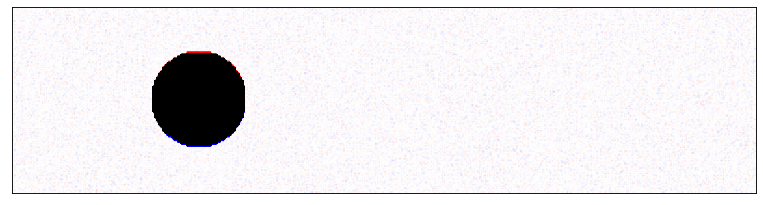

Vorticity plot at timestep: 0



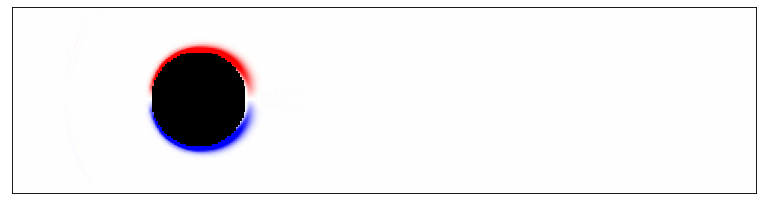

Vorticity plot at timestep: 100



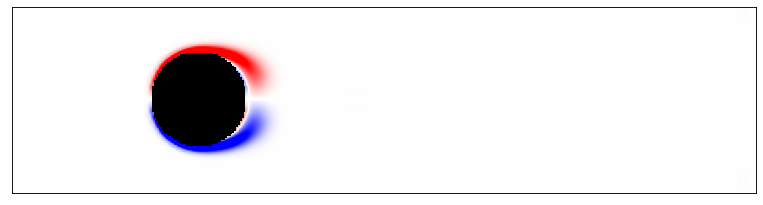

Vorticity plot at timestep: 200



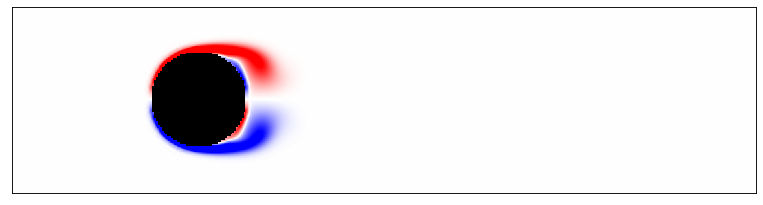

Vorticity plot at timestep: 300



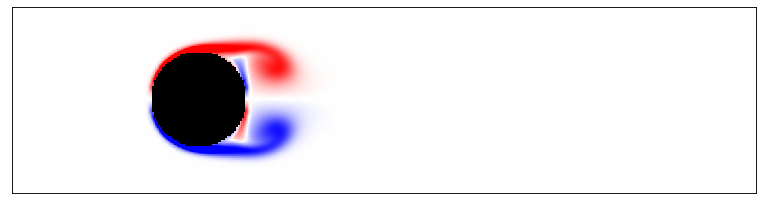

Vorticity plot at timestep: 400



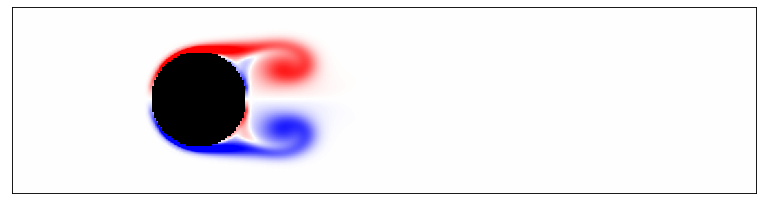

Vorticity plot at timestep: 500



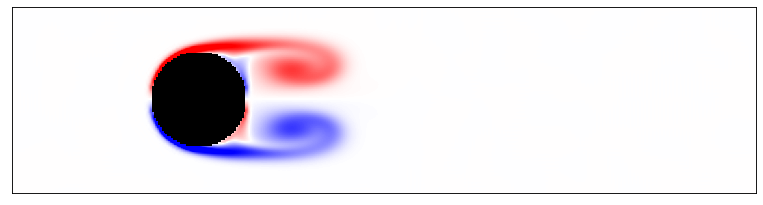

Vorticity plot at timestep: 600



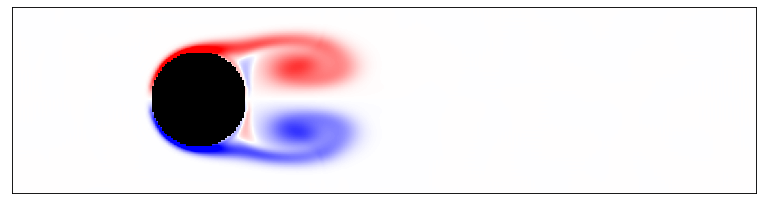

Vorticity plot at timestep: 700



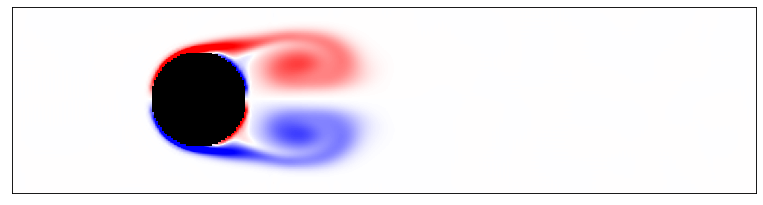

Vorticity plot at timestep: 800



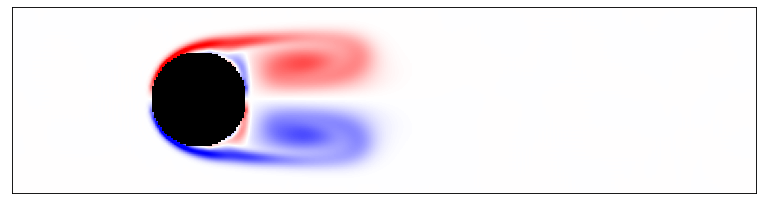

Vorticity plot at timestep: 900



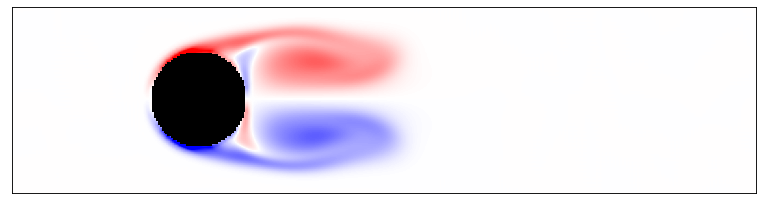

Vorticity plot at timestep: 1000



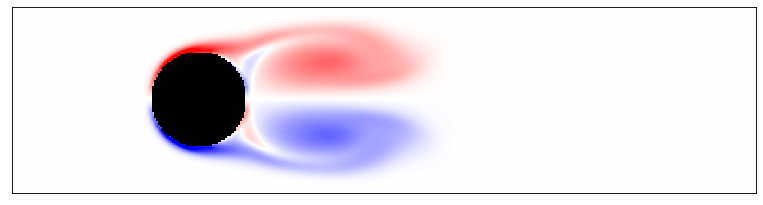

Vorticity plot at timestep: 1100



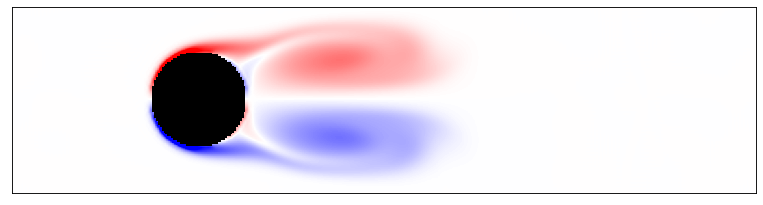

Vorticity plot at timestep: 1200



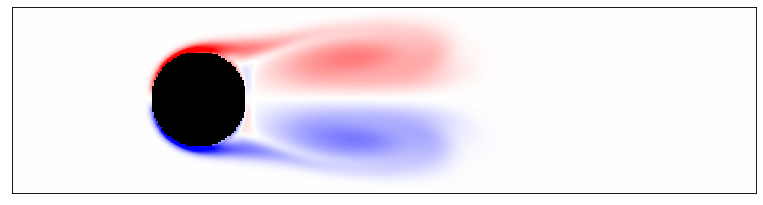

Vorticity plot at timestep: 1300



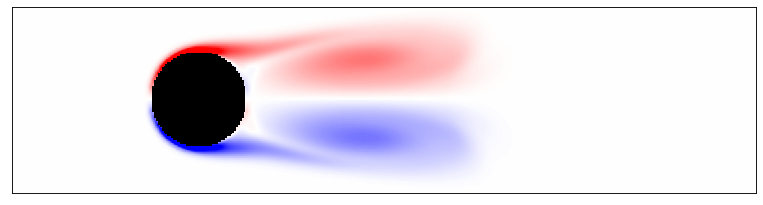

Vorticity plot at timestep: 1400



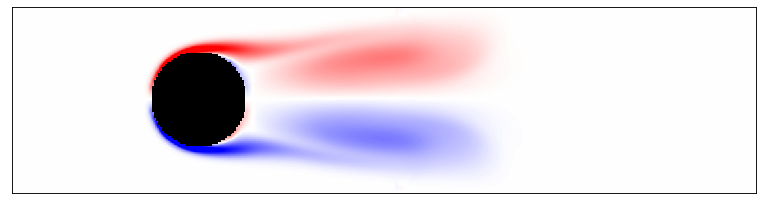

Vorticity plot at timestep: 1500



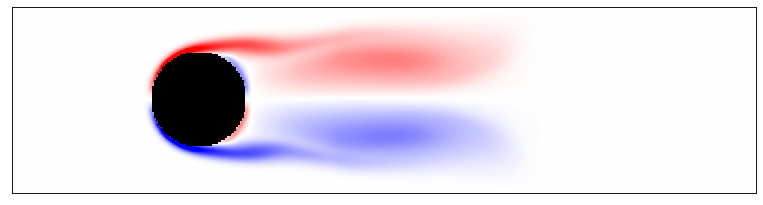

Vorticity plot at timestep: 1600



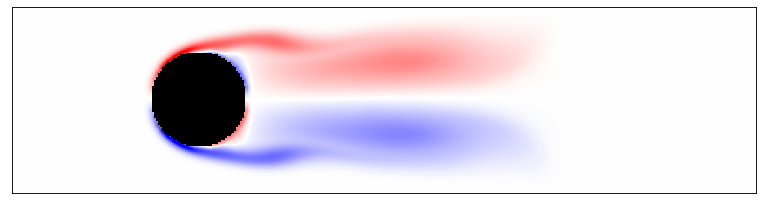

Vorticity plot at timestep: 1700



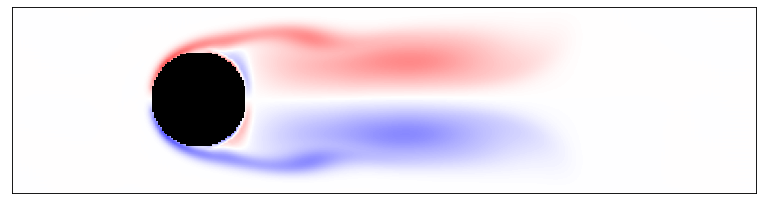

Vorticity plot at timestep: 1800



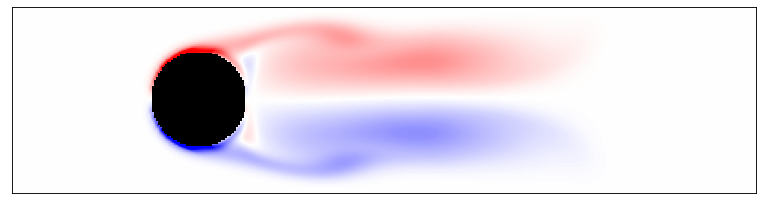

Vorticity plot at timestep: 1900



In [6]:
# connect a SmartRedis client to retrieve data while the
# simulation is producing it and storing it within the
# orchestrator database
client = Client(address=db.get_address()[0], cluster=False)

# Get the cylinder location in the mesh
client.poll_key(f"cylinder", 300, 1000)
cylinder = client.get_tensor("cylinder").astype(bool)

# plot every 100 timestep
for i in range(0, time_steps, 100): 
    client.poll_dataset(f"data_{i}", 300, 1000)
    dataset = client.get_dataset(f"data_{i}")
    ux, uy = dataset.get_tensor("ux"), dataset.get_tensor("uy")

    plot_lattice_vorticity(i, ux, uy, cylinder)

In [7]:
# Optionally clear the database
client.flush_db(db.get_address())

In [8]:
# Use the Experiment API to wait until the model
# is finished and then terminate the database and
# release it's resources
while not exp.finished(model):
    time.sleep(5)
    
exp.stop(db)


21:47:13 164b15ef4beb SmartSim[929] INFO fv_simulation(1061): Completed
21:47:14 164b15ef4beb SmartSim[929] INFO Stopping model orchestrator_0 with job name orchestrator_0-CN6NUV5BOVHL


In [9]:
exp.get_status(model)

['Completed']

In [10]:
exp.summary(format="html")

,Name,Entity-Type,JobID,RunID,Time,Status,Returncode
0,fv_simulation,Model,1061,0,48.9388,Completed,0
1,orchestrator_0,DBNode,1043,0,80.5271,Cancelled,-9
